# Overwatch League Regression Analysis
This project is an analysis on Overwatch League Data from the 2018 season. The data is pulled from https://overwatchleague.com/en-us/statslab?statslab=teamfights. This dataset contains 5 csv files, one for every stage of the season and another for the playoffs. We'll try to make a regression of time played on hero based off of other statistics.

## Project Justification
Why are we analyzing this dataset? I'm working with this dataset because me and some other students are looking to help UNCC's E-Sports Club with analytics. Specifically we are looking to help the Overwatch team and the Valorant team. This project both serves as good practice for the Club analytics and meets the requirements for ITSC 3162 Project 3

## Importing Packages
As always we'll be importing pandas, matplotlib, seaborn and numpy. We'll also import os so that we can work merge all the files in our directory into a dataframe.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## Understanding Our Data
Now we'll read in our data. Before we merge all of the files together into one dataframe, let's get an understanding of what a single file looks like. We'll look at the playoffs for this.

In [2]:
df = pd.read_csv('Data/phs_2018_playoffs.csv')

Looking at this we can see that each row appears to be a unique combination of match_id, map, player, hero and stat name. Ideally we want to get this down to be only a unique combination of match_id, map, player and hero with the stats being their own columns in this row. This will allow us to easily do modeling on our data. Let's look at our column datatypes and overview using .info.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55256 entries, 0 to 55255
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_time   55256 non-null  object 
 1   match_id     55256 non-null  int64  
 2   stage        55256 non-null  object 
 3   map_type     55256 non-null  object 
 4   map_name     55256 non-null  object 
 5   player       55256 non-null  object 
 6   team         55256 non-null  object 
 7   stat_name    55256 non-null  object 
 8   hero         55256 non-null  object 
 9   stat_amount  55256 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 4.2+ MB


We see that we only have 2 numeric columns. We also see that we have no nulls. Now let's check all of the stats we have. We will want to know what we'll add in our cleaned dataframe.

In [4]:
df['stat_name'].unique()

array(['All Damage Done', 'Assists', 'Average Time Alive',
       'Barrier Damage Done', 'Damage - Quick Melee', 'Damage Blocked',
       'Damage Done', 'Damage Taken', 'Deaths', 'Eliminations',
       'Final Blows', 'Hero Damage Done', 'Melee Final Blows',
       'Melee Percentage of Final Blows', 'Objective Kills',
       'Objective Time', 'Offensive Assists', 'Shots Fired', 'Time Alive',
       'Time Building Ultimate', 'Time Elapsed per Ultimate Earned',
       'Time Holding Ultimate', 'Time Played',
       'Ultimates Earned - Fractional', 'Ultimates Used',
       'Weapon Accuracy', 'Damage - Weapon', 'Damage Amplified',
       'Eliminations per Life', 'Players Halted', 'Quick Melee Accuracy',
       'Quick Melee Hits', 'Quick Melee Ticks', 'Secondary Fire Accuracy',
       'Shots Hit', 'Shots Missed', 'Damage - Jump Pack',
       'Damage - Primal Rage Melee', 'Damage - Primal Rage Total',
       'Jump Pack Kills', 'Melee Kills', 'Players Knocked Back',
       'Primal Rage Melee Ac

Looking at this we see a lot of stats that are very hero specific. We'll want to ignore these. Let's look at all the stats available to all heroes. 

In [5]:
df[df['hero'] == 'All Heroes']['stat_name'].unique()

array(['All Damage Done', 'Assists', 'Average Time Alive',
       'Barrier Damage Done', 'Damage - Quick Melee', 'Damage Blocked',
       'Damage Done', 'Damage Taken', 'Deaths', 'Eliminations',
       'Final Blows', 'Hero Damage Done', 'Melee Final Blows',
       'Melee Percentage of Final Blows', 'Objective Kills',
       'Objective Time', 'Offensive Assists', 'Shots Fired', 'Time Alive',
       'Time Building Ultimate', 'Time Elapsed per Ultimate Earned',
       'Time Holding Ultimate', 'Time Played',
       'Ultimates Earned - Fractional', 'Ultimates Used',
       'Weapon Accuracy', 'Defensive Assists', 'Healing Done',
       'Solo Kills', 'Environmental Deaths', 'Recon Assists',
       'Multikills', 'Environmental Kills'], dtype=object)

This is a much better list. We'll look to this list when trying to consolidate our data.

### Merging Our Files
Now we'll merge our data from our 5 files into one dataframe. We'll be using the os package for this. We'll read in all of the files from our directory, besides the one we've already read in, and concatinate it onto our dataframe we already have. We'll be referencing this article to acomplish this: https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/.

In [6]:
directory = 'Data'
for file in os.listdir(directory):
    f = os.path.join(directory, file)
    if f != "Data/phs_2018_playoffs.csv":
        df2 = pd.read_csv(f)
        df = pd.concat([df,df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179674 entries, 0 to 285041
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   start_time   1179674 non-null  object 
 1   match_id     1179674 non-null  int64  
 2   stage        1179674 non-null  object 
 3   map_type     1179674 non-null  object 
 4   map_name     1179674 non-null  object 
 5   player       1179674 non-null  object 
 6   team         1179674 non-null  object 
 7   stat_name    1179674 non-null  object 
 8   hero         1179674 non-null  object 
 9   stat_amount  1179674 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 99.0+ MB


## Creating a Clean Dataframe
Now that we have all of the data merged, let's go through and actually try to make the dataframe useable. For this we'll create dummy columns of the stat's we want and group our dataframe into the columns we want. Before we do this, we'll factor out our unnecessary data (rows that contain all heroes are useless to us). We'll also drop all duplicates.

In [7]:
df = df[df['hero'] != 'All Heroes'].drop_duplicates()

Now let's create our new dataframe. The features we'll include are map_name, hero, all damage done, average time alive, deaths, hero damage done, offensive assists, time building ultimate, healing done, objective time, and time played. This will hopefully be a good set of features to use.

In [8]:
column_names = ['Time Alive','Deaths','Damage Done','Offensive Assists', 'Ult Time','Healing','Objective Time',
               'Time Played']
stat_names = ["Average Time Alive","Deaths","Hero Damage Done","Offensive Assists","Time Elapsed per Ultimate Earned",
            "Healing Done","Objective Time","Time Played"]

Now we'll create the dummy columns we'll be using and multiply them by the stat value. 

In [9]:
for index in list(range(len(column_names))):
    df[column_names[index]] = df['stat_name'] ==stat_names[index]
    df[column_names[index]] = df[column_names[index]] * df['stat_amount']

Finally we'll group our dataframe by the unique identifier we want and sum our dummy columns. This will result in a clean dataframe. We'll call this new grouped dataframe working df.

In [10]:
working_df = df.groupby(['match_id','map_name','player','hero'])[column_names].sum()

Grouped dataframes look kinda weird. We want to get the dataframe looking nice, so we'll reset the index to get a normal dataframe.

In [11]:
working_df = working_df.reset_index()

Now we need to verify data integrity by filtering out any rows that don't have an average time alive or time played. This is because someone would have to play at least one second to show up. 

In [12]:
working_df = working_df[~((working_df['Time Alive'] == 0)|(working_df['Time Played'] == 0))]

Finally we want to create a dummy column for heroes. We do this because certain heroes have different stat weights and we need something to handle this. We'll divide hero dummies into the different role categories.

In [13]:
tanks = ['D.Va','Winston','Zarya','Reinhardt','Roadhog','Orisa']
dps = ['Tracer','Soldier: 76','Widowmaker', 'McCree', 'Pharah', 'Genji',
      'Junkrat','Doomfist', 'Reaper', 'Torbjörn', 'Sombra', 'Hanzo', 'Mei',
       'Symmetra', 'Bastion']
support = ['Lúcio', 'Mercy','Zenyatta', 'Ana','Moira','Brigitte']

Now that we have our different role categories, let's create dummy columns for them.

In [14]:
working_df['Tanks'] = [0] * len(working_df)
working_df['Damage'] = [0] * len(working_df)
working_df['Support'] = [0] * len(working_df)
working_df.loc[working_df['hero'].isin(tanks),'Tanks'] = 1
working_df.loc[working_df['hero'].isin(dps),'Damage'] = 1
working_df.loc[working_df['hero'].isin(support),'Support'] = 1

Here is our final dataframe for this section.

In [15]:
working_df

,match_id,map_name,player,hero,Time Alive,Deaths,Damage Done,Offensive Assists,Ult Time,Healing,Objective Time,Time Played,Tanks,Damage,Support
15,10223,Ilios,Danteh,Tracer,83.372377,6.0,11773.954530,0.0,64.000189,0.000000,84.189003,725.219299,0,1,0
16,10223,Ilios,Envy,D.Va,96.529146,5.0,11043.024780,0.0,47.278730,0.000000,76.202002,721.333075,1,0,0
17,10223,Ilios,Envy,Soldier: 76,3.765000,0.0,0.000000,0.0,517.825012,0.000000,0.000000,3.886224,0,1,0
18,10223,Ilios,Fate,Winston,66.758602,8.0,9545.177218,0.0,90.769549,0.000000,87.577003,725.219299,1,0,0
19,10223,Ilios,KariV,Lúcio,2.219000,0.0,0.000000,0.0,873.731285,0.000000,0.000000,3.892819,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26090,13134,Lijiang Tower,carpe,Widowmaker,41.558287,6.0,3869.311810,0.0,95.220466,0.000000,3.059000,342.585886,0,1,0
26091,13134,Lijiang Tower,eqo,Pharah,35.484201,3.0,1769.877926,0.0,131.700532,0.000000,1.435000,205.331237,0,1,0
26092,13134,Lijiang Tower,eqo,Tracer,79.502502,3.0,1894.675310,0.0,71.401840,0.000000,21.882001,191.753660,0,1,0
26093,13134,Lijiang Tower,neptuNo,Lúcio,5.838000,0.0,0.000000,0.0,681.100008,0.000000,0.000000,9.728096,0,0,1


## Feature Visualizations
Now that we have a clean dataframe, we'll go through and see how our features are distributed.

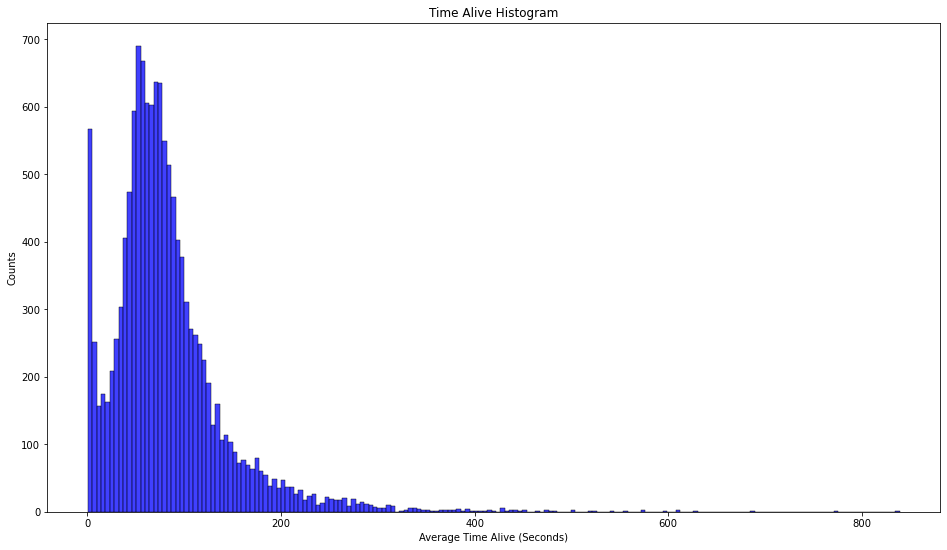

In [16]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Time Alive'],color='Blue')
plt.title("Time Alive Histogram")
plt.ylabel("Counts")
plt.xlabel("Average Time Alive (Seconds)")
plt.show()

This almost looks normally distributed except for the leftmost bin. Since I have played Overwatch, I can tell you that this happening because people switch to characters to stall and they instantly die.

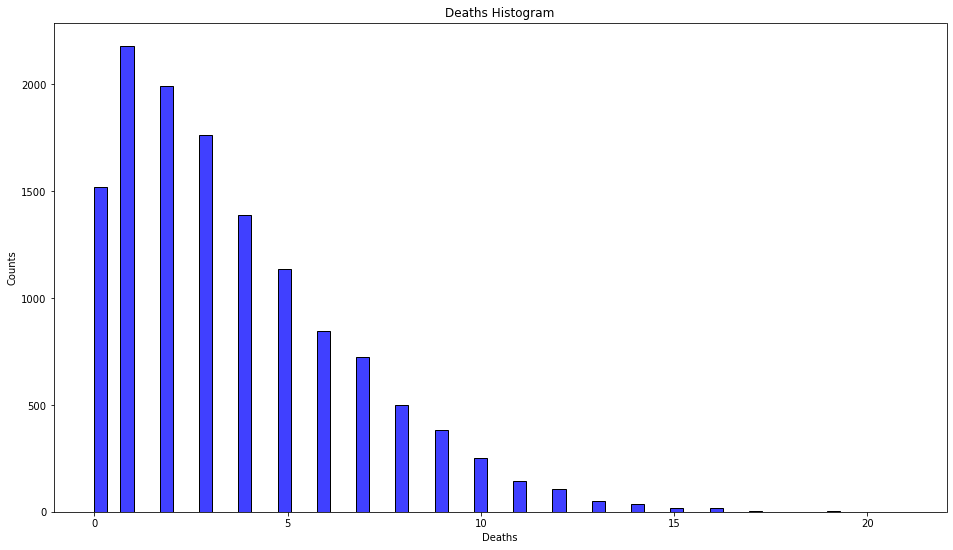

In [17]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Deaths'],color='Blue')
plt.title("Deaths Histogram")
plt.ylabel("Counts")
plt.xlabel("Deaths")
plt.show()

This looks almost like a chi-squared curve. There are no obvious outliers here.

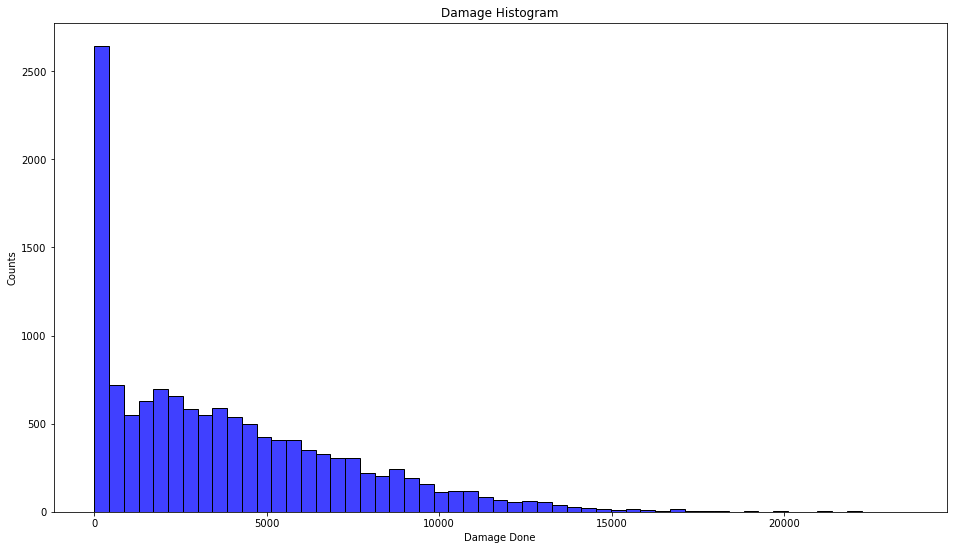

In [18]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Damage Done'],color='Blue')
plt.title("Damage Histogram")
plt.ylabel("Counts")
plt.xlabel("Damage Done")
plt.show()

This looks pretty good as well. Like the average time alive, the damage done is skewed because of stalling at the end of a match.

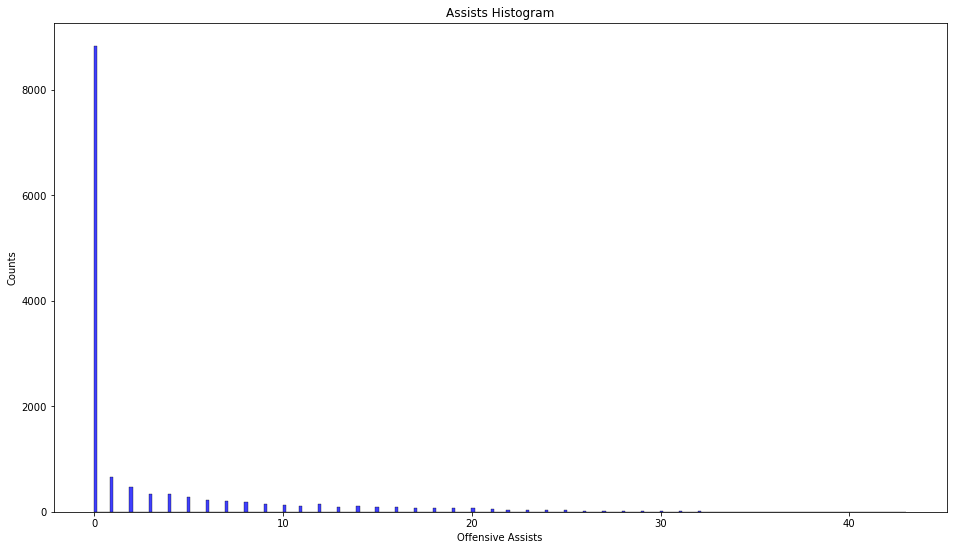

In [19]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Offensive Assists'],color='Blue')
plt.title("Assists Histogram")
plt.ylabel("Counts")
plt.xlabel("Offensive Assists")
plt.show()

This makes sense because not all heroes have access to offensive asssists. This is part of the reason that we dummy variables for heroes. 

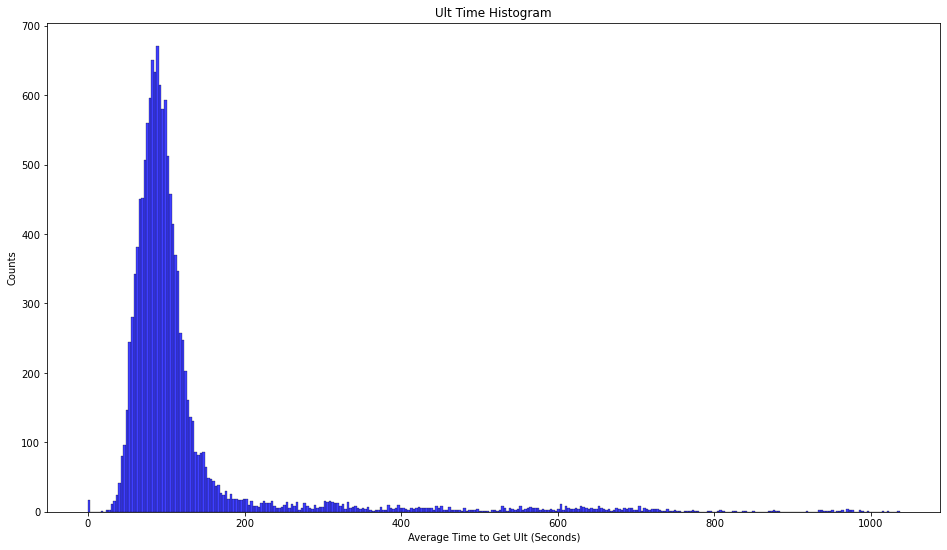

In [20]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Ult Time'],color='Blue')
plt.title("Ult Time Histogram")
plt.ylabel("Counts")
plt.xlabel("Average Time to Get Ult (Seconds)")
plt.show()

This is a beautiful curve. Nice and normally distributed. This might be a good feature for predicting time played.

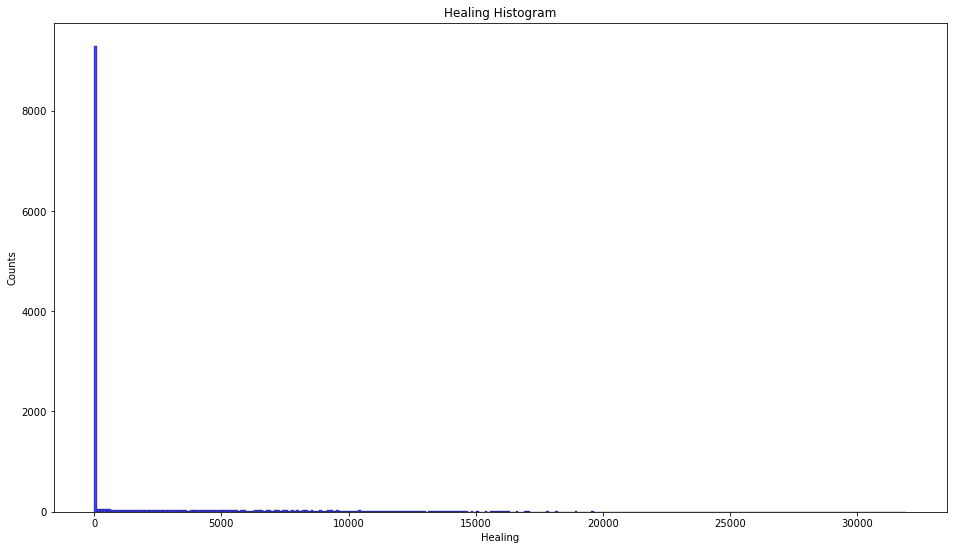

In [21]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Healing'],color='Blue')
plt.title("Healing Histogram")
plt.ylabel("Counts")
plt.xlabel("Healing")
plt.show()

This is very similar to offensive assists. The happens for the same reason as offensive assists.

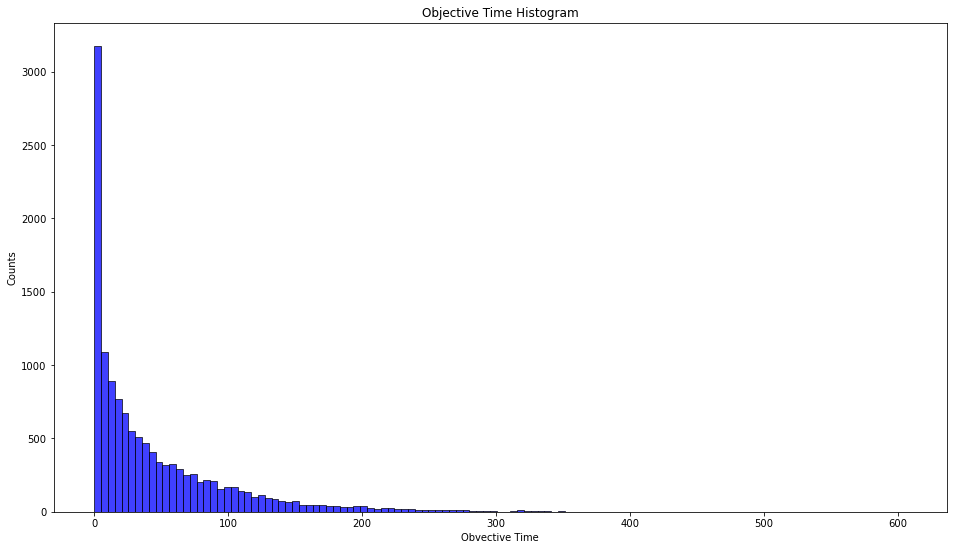

In [22]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Objective Time'],color='Blue')
plt.title("Objective Time Histogram")
plt.ylabel("Counts")
plt.xlabel("Obvective Time")
plt.show()

This distribution also makes a lot of sense and we can see that objective time might correlate with time alive.

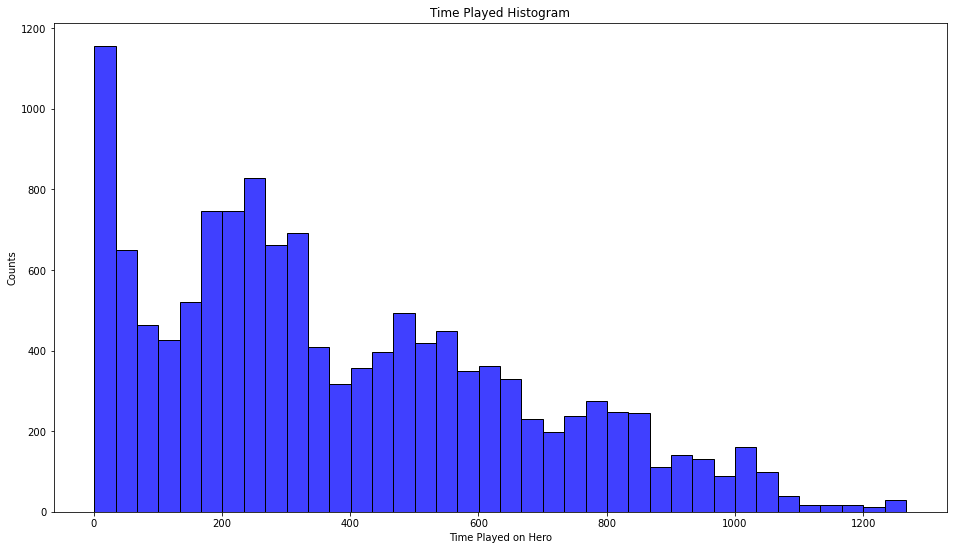

In [23]:
plt.figure(figsize=(16,9))
sns.histplot(working_df['Time Played'],color='Blue')
plt.title("Time Played Histogram")
plt.ylabel("Counts")
plt.xlabel("Time Played on Hero")
plt.show()

This distribtuion is the most interesting one we see. The data seems to have rolling spots that might almost immitate a decreasing harmonic function.


The last thing we'll do with our visualizations is build a correlation heatmap of our data. We'll include the roles into this heatmap even though we didn't have the distribution. 

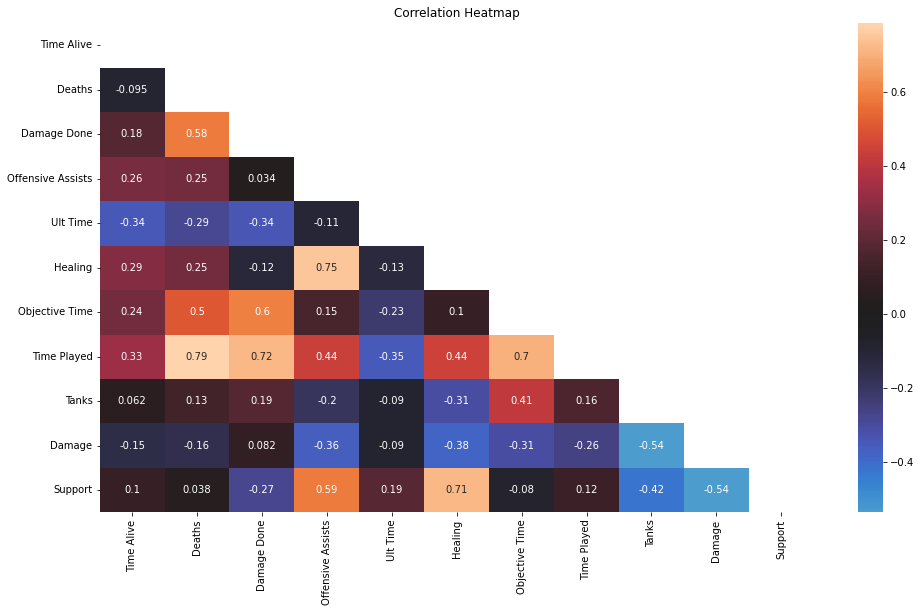

In [24]:
mask = np.triu(np.ones_like(working_df[['Time Alive','Deaths','Damage Done','Offensive Assists',
                       'Ult Time','Healing','Objective Time','Time Played','Tanks','Damage','Support']].corr()))
plt.figure(figsize=(16,9))
sns.heatmap(working_df[['Time Alive','Deaths','Damage Done','Offensive Assists',
                       'Ult Time','Healing','Objective Time','Time Played','Tanks','Damage','Support']].corr(),
           center=0,annot=True,mask=mask)
plt.title('Correlation Heatmap')
plt.show()

They key points we care about here have to do with time played. Looking at the plot, we see that deaths, damage done, and object time have the highest correlation with time played. Healing and offensive assists are also decently correlated, but aren't as important. This is likely due to these stats only being available to healers. We might need to thow in interaction variables between heroes and these stats. We also see that healing and offensive assists are highly correlated. 

## Model Building
### Experiment 1
Now we'll create our first model. For this first model we won't be adding interaction variables. We'll be utilizing a linear regression for our first model. Linear regression models fit a line of best fit to your data and predicts points on that line. The line of best fit by finding using the sum of squared errors as a metric for optimization. The sum of squared errors is a convex function and can therefore be optimized using the gradient descent algorithm to find the optimal values of the line. Alternatively, ordinary least square models can be found by doing matrix multiplication on the data which is how the package we'll be using finds the line of best fit. There's a little more nuance to this explanation, such as the line predicting the mean point and not the actual point, but it's easiest to just think of linear regression as your standard y=mx+b. Since we are using many variables our equation can be better explained as following y = m1x1 + m2x2 + .... + mnxn + b where m1 is your first slope of your first feature and m2 is the second and so on. 

We'll import model selection and metrics from sklearn and use the statsmodels package for ordinary least squares regression. This will give us more advanced statistics than what is available in sklearn.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sma

Now we'll split our data into training and testing.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(working_df.drop(columns=[
    'hero','match_id','map_name','player','Time Played']),
                                                   working_df['Time Played'], test_size = .2,
                                                   random_state = 2)

Now we'll create our linear regression and fit the data.

In [27]:
Reg = sma.OLS(y_train,X_train)
Reg = Reg.fit()

Now we'll look at the summary of our model provided by the statsmodels package.

In [28]:
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:            Time Played   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.462e+04
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:22:53   Log-Likelihood:                -60230.
No. Observations:               10453   AIC:                         1.205e+05
Df Residuals:                   10443   BIC:                         1.206e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Time Alive            0.8183      0.01

There is a lot to unpack here, but the key takeaway is that our model is useful since our F-stat is so high. Also of note, all of our features are considered significant as the probablity that the coeffecients are equal to 0 is roughly zero. We also see all of the coeffiecients and their 95% confidence intervals as well as the R-squared of the training set. Our R-sqaured value is very high so we should be happy with our model. Now let's go through and get the metrics on the testing set.

In [29]:
predictions = Reg.predict(X_test)
print('R-Squared Value:',metrics.r2_score(y_test,predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,predictions))
print('Root Mean Squared Error:',metrics.mean_squared_error(y_test,predictions)**.5)
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,predictions))

R-Squared Value: 0.9229245709859968
Mean Squared Error: 5861.104271302538
Root Mean Squared Error: 76.55784918153421
Mean Absolute Error: 55.43814376398635


The only thing we can interpret from this is the R-squared value. The R-squared value of .923 is extremely good for a first time run through the model. We should also check how the other metrics hold up. To do so let's get the distribution of our target variable.

In [30]:
working_df['Time Played'].describe()

count    13067.000000
mean       384.623767
std        282.190398
min          0.970008
25%        171.288129
50%        313.473912
75%        572.318514
max       1266.702449
Name: Time Played, dtype: float64

Now that we see our standard deviation, we see that on average we are withing 1/4 of a standard deviation for root mean squared error and within 1/6 of a standard deviaiton for mean absolute error. This is very good. Let's check to see how our residuals are distributed to see if our linear model isn't too skewed.

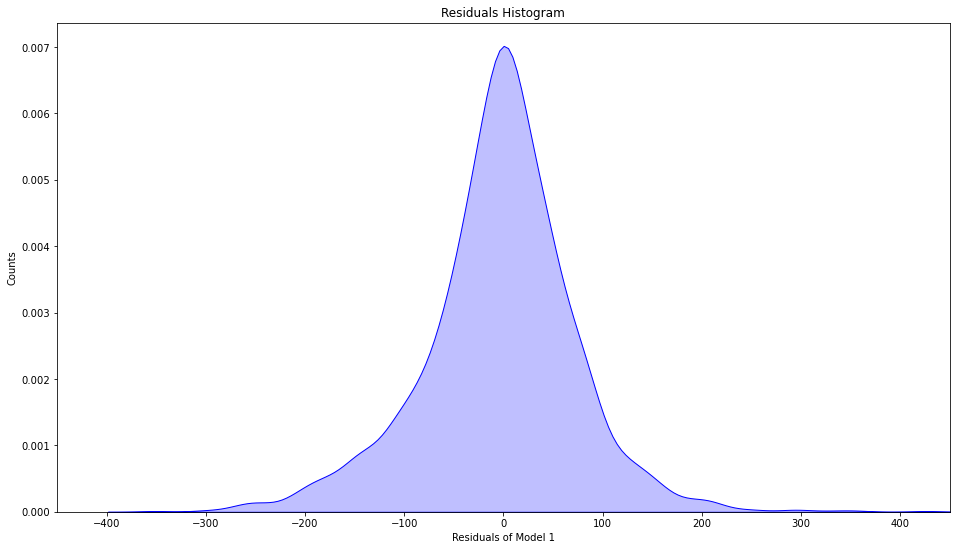

In [31]:
residuals = predictions - y_test
fig, ax = plt.subplots(figsize=(16,9))
sns.kdeplot(residuals,color='Blue',ax=ax,fill=True)
ax.set_xlim(-450,450)
plt.title("Residuals Histogram")
plt.ylabel("Counts")
plt.xlabel("Residuals of Model 1")
plt.show()

This is a good residual distribution. The residual distribution of a linear model should roughly be normal and this distribution looks like its normal enough. We can also create a QQ-plot to ensure it is normal. Luckily the statsmodels package already has an implementation for this. If the data is good for a linear model we should see a 45 degree linear trend on the plot. 

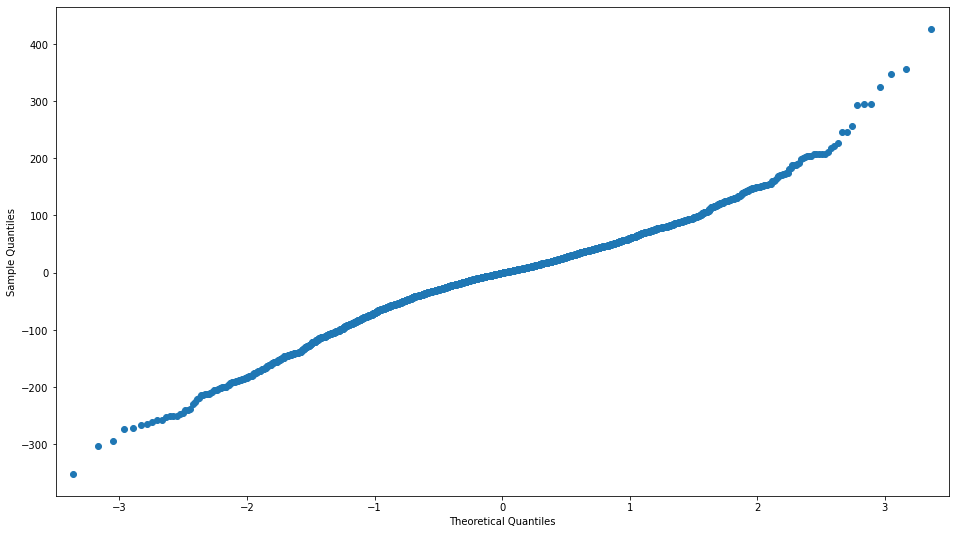

In [32]:
sma.qqplot(residuals).set_size_inches(16,9)
plt.show()

This model isn't exactly a 45 degree angle so maybe using a linear model isn't the best choice. Let's move into feature engineering some interaction variables to see if we have a better model.

### Experiment 2
This experiment will also use a linear regression with some interaction variables. Interaction variables are feature engineered variables that are the multiplacation of 2 different features. The idea is that interaction variables are able to encapsulate how different variables interact with each other. Our goal with this section is to create interaction variables for roles and the support role as supports typically aren't built for damage. Now it's time to get started.

We'll create a new dataframe to use so we still have the old one as a checkpoint incase we decide to come back to it.

In [33]:
working_df2 = working_df.copy()

Now we'll create 3 interaction variables for supports: assists, damage, and healing interaction variables.

In [34]:
for variable in ['Offensive Assists','Damage Done','Healing']:
    for role in ['Tanks','Damage','Support']:
        interaction = role +' x ' + variable
        working_df2[interaction] = working_df2[variable] * working_df2[role]

Now that we have our interaction variables, let's go through and recreate everything we did in experiment 1 with our new dataframe.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(working_df2.drop(columns=[
    'hero','match_id','map_name','player','Time Played']),
                                                   working_df['Time Played'], test_size = .2,
                                                   random_state = 2)
X_train = sma.add_constant(X_train)
Reg = sma.OLS(y_train,X_train)
Reg = Reg.fit()
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:            Time Played   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.166e+04
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:22:54   Log-Likelihood:                -59175.
No. Observations:               10453   AIC:                         1.184e+05
Df Residuals:                   10438   BIC:                         1.185e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Something interesting happened in this model vs the last one. When we introduce interaction variables for supports, our tank feature actually stops being significant. This means that we might be able to drop the tank feature and keep performance. Again let's go through the stats for this model on the testing set.

In [36]:
predictions = Reg.predict(sma.add_constant(X_test))
print('R-Squared Value:',metrics.r2_score(y_test,predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,predictions))
print('Root Mean Squared Error:',metrics.mean_squared_error(y_test,predictions)**.5)
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,predictions))

R-Squared Value: 0.9355230468875229
Mean Squared Error: 4903.068982197351
Root Mean Squared Error: 70.02191787003089
Mean Absolute Error: 50.04035018741558


We can see from our metrics on the testing set that this second model actually performs better than the last one. We could consider adding more interaction variables into this regression model. Let's check if the residual distribution and QQ-plot are better this time or not.

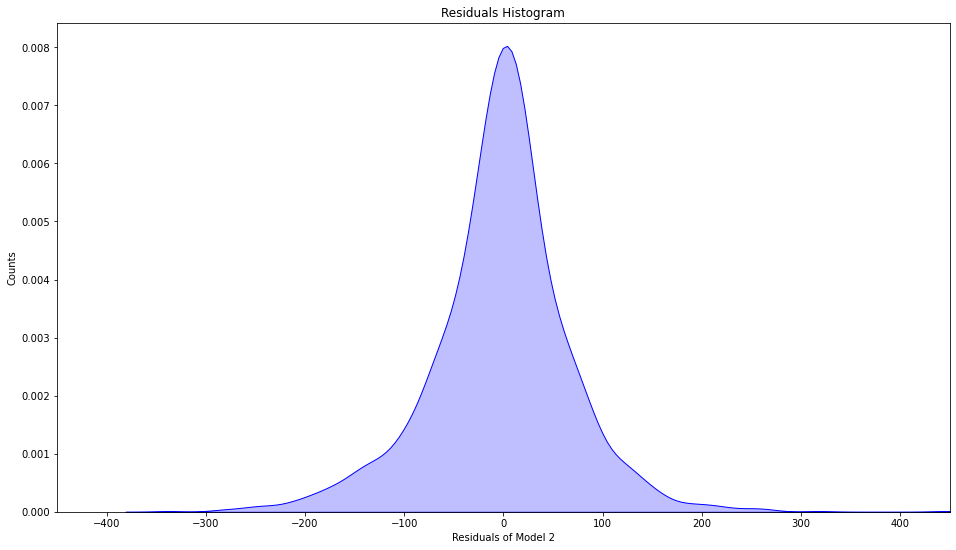

In [37]:
residuals = predictions - y_test
fig, ax = plt.subplots(figsize=(16,9))
sns.kdeplot(residuals,color='Blue',ax=ax,fill=True)
ax.set_xlim(-450,450)
plt.title("Residuals Histogram")
plt.ylabel("Counts")
plt.xlabel("Residuals of Model 2")
plt.show()

This looks more normally distributed than our last residual plot. Let's check if the QQ-plot looks like it fits.

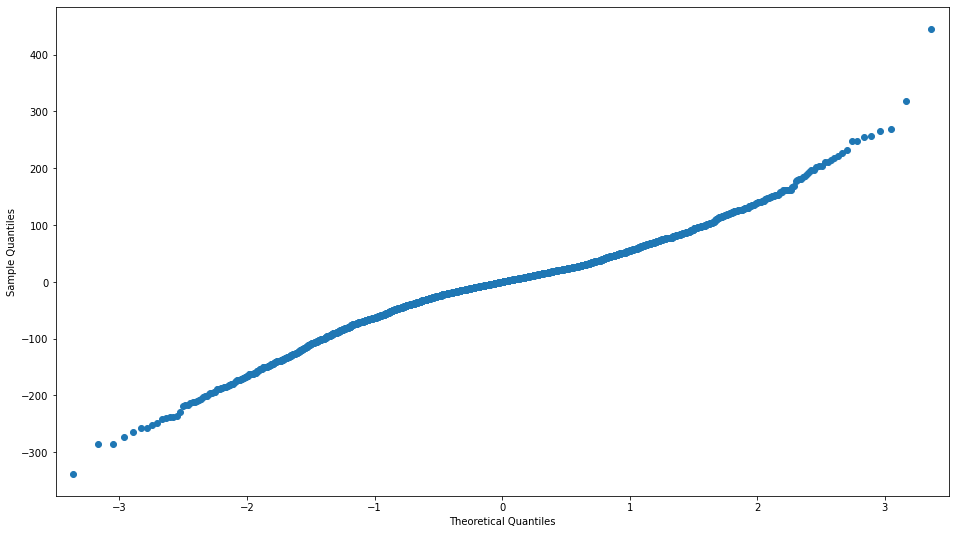

In [38]:
sma.qqplot(residuals).set_size_inches(16,9)
plt.show()

This QQ-plot actually looks like it's less linear than the last one. We should consider not using a linear model for this problem then. Let's try using a non-linear regressor such as a decision tree now. 

### Experiment 2 with PCA
Because we have so many features, let's reduce our features by doing PCA. The goal here is to use PCA to better help the interpretation of the model.

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Now let's transform our data. We'll reassign the data to a new data frame as to not mess with the original data used. We'll also scale our features.

In [40]:
X = working_df2.drop(columns=['hero','match_id','map_name','player','Time Played']).copy()
y = working_df2['Time Played']
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)

Now let's do PCA on our data.

In [41]:
X_PCA = PCA(n_components = len(X.columns))
X_PCA = X_PCA.fit(X)

We've now created as many principal components as we have columns. In order to do featuer reduction, let's see how much data is encapsulated in each of the components. We'll use a scree plot for this.

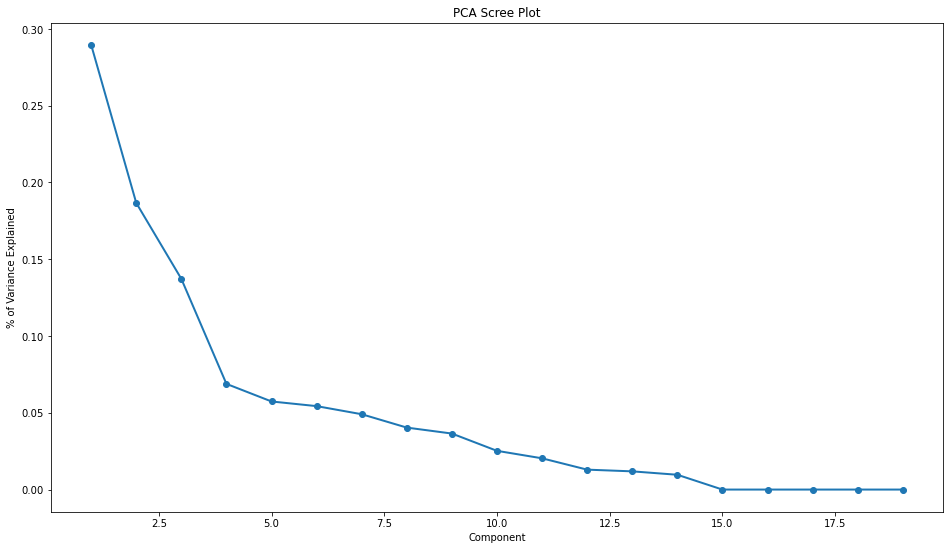

In [42]:
plt.figure(figsize=(16,9))
plt.plot(np.arange(X_PCA.n_components_)+1,X_PCA.explained_variance_ratio_,'o-',linewidth=2)
plt.xlabel('Component')
plt.ylabel('% of Variance Explained')
plt.title('PCA Scree Plot')
plt.show()

Looking at these components, we can see that the variation explained starts to drop off at around around 14. After 14, our components start to have close to 0 variance explained. Because of this we'll only use 14 components.

In [43]:
X_PCA = PCA(n_components = 14)
X_PCA = X_PCA.fit(X)

Now we'll go through and create our linear regression model. It's important that we add a constant for this regression as the principal components won't work in the exact same way as our original predictors. Not including a constant could lead to our predictions being offset.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA.transform(X),
                                                   y, test_size = .2,
                                                   random_state = 2)
X_train = sma.add_constant(X_train)
Reg = sma.OLS(y_train,X_train)
Reg = Reg.fit()
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:            Time Played   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.166e+04
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:22:54   Log-Likelihood:                -59175.
No. Observations:               10453   AIC:                         1.184e+05
Df Residuals:                   10438   BIC:                         1.185e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        383.9776      0.681    563.946      0.0

In [45]:
predictions = Reg.predict(sma.add_constant(X_test))
print('R-Squared Value:',metrics.r2_score(y_test,predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,predictions))
print('Root Mean Squared Error:',metrics.mean_squared_error(y_test,predictions)**.5)
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,predictions))

R-Squared Value: 0.935523046887523
Mean Squared Error: 4903.068982197343
Root Mean Squared Error: 70.02191787003083
Mean Absolute Error: 50.04035018741561


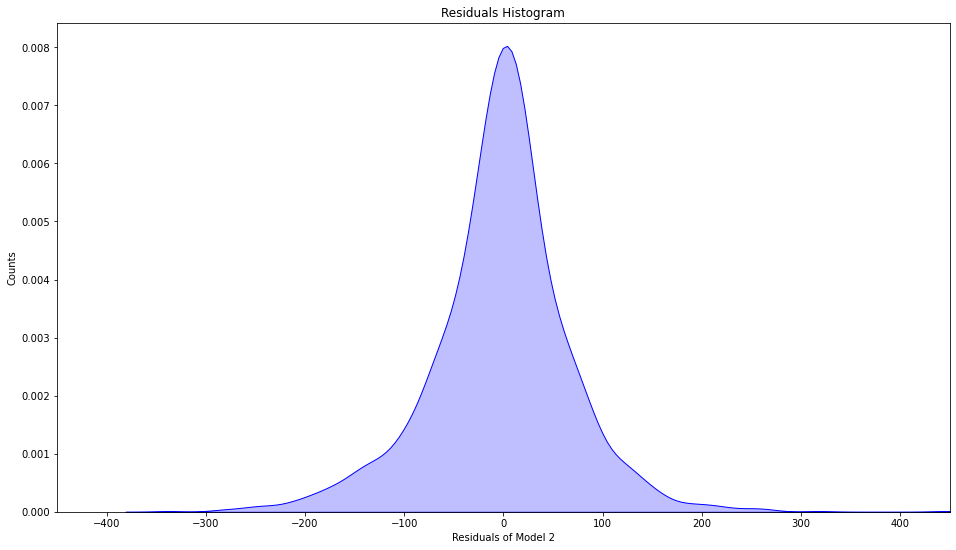

In [46]:
residuals = predictions - y_test
fig, ax = plt.subplots(figsize=(16,9))
sns.kdeplot(residuals,color='Blue',ax=ax,fill=True)
ax.set_xlim(-450,450)
plt.title("Residuals Histogram")
plt.ylabel("Counts")
plt.xlabel("Residuals of Model 2")
plt.show()

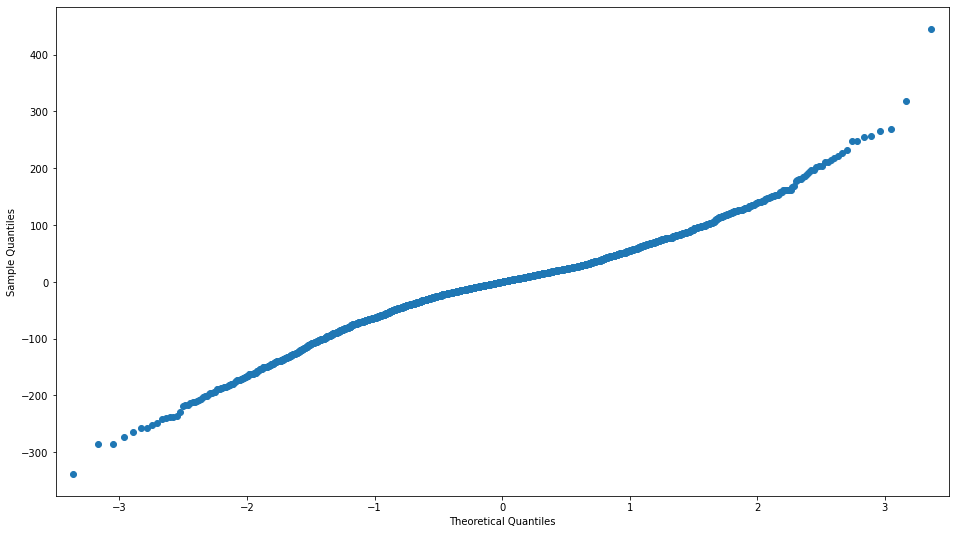

In [47]:
sma.qqplot(residuals).set_size_inches(16,9)
plt.show()

### Experiment 3
Since our linear models didn't fit the way we wanted them to, we'll use a non-linear model to hopefully get better results. For our non-linear model we'll be utilizing a gradient boosting regressor from sklearn. The gradient boosting regressor is an ensemble tree based model that uses a bunch of weak regressors and combines them for strong regressor. Since we're using sklearn, we won't have the output from the statsmodels package. Instead we'll only be measuring our metrics from the sklearn metrics.

Since the gradient boosting regressor uses tree based methods we don't need the interaction variables created in experiment 2. Because of this we'll be utilizing our original working dataframe. We'll need to go back and run the same split in our working dataframe and fit it to the regressor.

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, y_train, y_test = train_test_split(working_df.drop(columns=[
    'hero','match_id','map_name','player','Time Played']),
                                                   working_df['Time Played'], test_size = .2,
                                                   random_state = 2)
Reg = GradientBoostingRegressor(random_state = 7)
Reg = Reg.fit(X_train,y_train)

Now that we've fit the data, let's evaulate the model.

In [49]:
predictions = Reg.predict(X_test)
print('R-Squared Value:',metrics.r2_score(y_test,predictions))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,predictions))
print('Root Mean Squared Error:',metrics.mean_squared_error(y_test,predictions,squared=False))
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,predictions))

R-Squared Value: 0.9580490225314211
Mean Squared Error: 3190.1094339900797
Root Mean Squared Error: 56.481053761328496
Mean Absolute Error: 40.98802517355983


We can see that this model not only has a higher R-squared value, but also has a lower mean squared error and mean absolute error. Let's check how the residuals are distributed in our data.

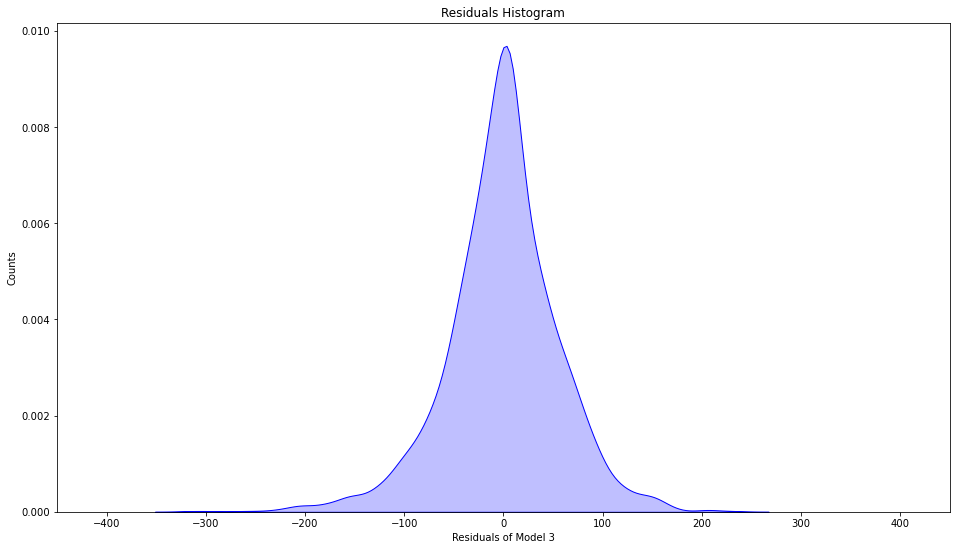

In [50]:
residuals = predictions - y_test
fig, ax = plt.subplots(figsize=(16,9))
sns.kdeplot(residuals,color='Blue',ax=ax,fill=True)
ax.set_xlim(-450,450)
plt.title("Residuals Histogram")
plt.ylabel("Counts")
plt.xlabel("Residuals of Model 3")
plt.show()

It looks like our residuals are not normally distributed here. This means that there is some level of bias in our model that makes it skew. We can do parameter tuning of the gradient boosting classifier to hopefully fix this problem, but we'll ignore this for now. Let's check the QQ-plot to make sure that we are correct in saying that the model is more biased.

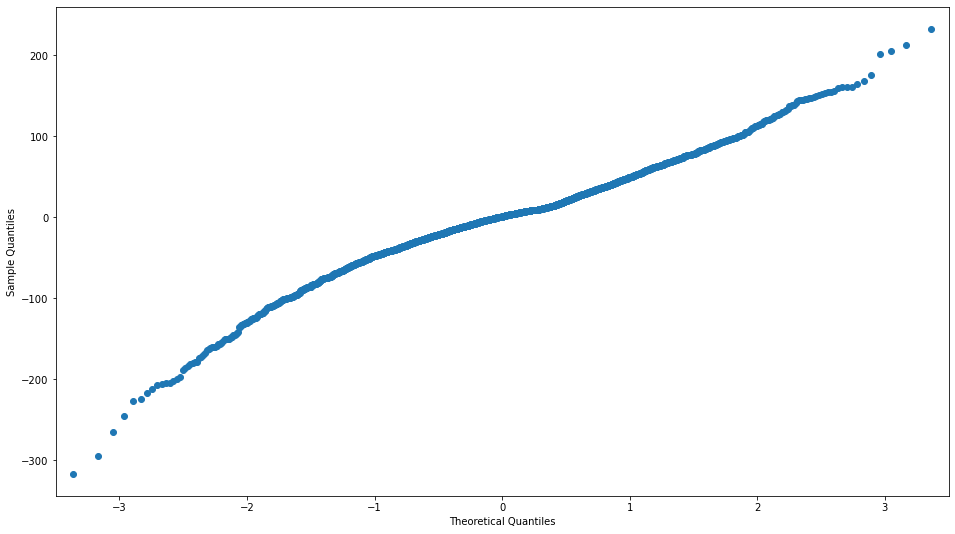

In [51]:
sma.qqplot(residuals).set_size_inches(16,9)
plt.show()

As we can see from the QQ-plot, our model has some bias in it. This makes sense as tree based models are prone to overfitting very easily. As stated earlier we can absolutely do some feature engineering in order to make the model better, and if an experiment 4 was required that would be done. However this model performed excellently for the regression and we should be happy with the results we got.

## Impact
Since this project is similar to what I might be doing working with the UNCC esports club, this will hopefully translate well into what I do over there. As for what the actual impact and take aways are from this project, unfortunately this doesn't have very practical applications for the game. The information used to create the regression models cannot be used in game to predict when someone will swap. This project will end up being a demonstration of the methodolies of regression problems, both linear and non-linear.

## Conclusion
The big thing that came out of this project is the process taken for regression problems. We get to see how linear regressions work and how we can evaluate them in comparison to classification problems. We also see how other algorthims can be used for regression problems and perform better. There is a huge downside to using more complicated ensemble algorithms, explainability. As we saw with the statmodels package, linear models have a lot of performance metrics to them that can be utilized to help figure out what is important and not. Being able to have statistics that tell what features are important or not is nice. It also allows us to understand how our features are affected by introducing different features. For example, when we introduced our interaction variables, we saw that the tank dummy column became non-significant. This gave us very simple understanding into how our model could be further tuned in order to provide better performance. Overall, I think this was a good practice on how to work with regression problems and in how we can feature engineer problems to capture non-linear interaction in a linear model.

## Works Cited
As always here are the sources and packages used in this notebook
- sklearn - @article{scikit-learn,
     title={Scikit-learn: Machine Learning in {P}ython},
     author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
     and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
     and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
     Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
     journal={Journal of Machine Learning Research},
     volume={12},
     pages={2825--2830},
     year={2011}
    }
- numpy - @Article{         harris2020array,
     title         = {Array programming with {NumPy}},
     author        = {Charles R. Harris and K. Jarrod Millman and St{\'{e}}fan J.
    van der Walt and Ralf Gommers and Pauli Virtanen and David
    Cournapeau and Eric Wieser and Julian Taylor and Sebastian
    Berg and Nathaniel J. Smith and Robert Kern and Matti Picus
    and Stephan Hoyer and Marten H. van Kerkwijk and Matthew
    Brett and Allan Haldane and Jaime Fern{\'{a}}ndez del
    R{\'{i}}o and Mark Wiebe and Pearu Peterson and Pierre
    G{\'{e}}rard-Marchant and Kevin Sheppard and Tyler Reddy and
    Warren Weckesser and Hameer Abbasi and Christoph Gohlke and
    Travis E. Oliphant},
     year          = {2020},
     month         = sep,
     journal       = {Nature},
     volume        = {585},
     number        = {7825},
     pages         = {357--362},
     doi           = {10.1038/s41586-020-2649-2},
     publisher     = {Springer Science and Business Media {LLC}},
     url           = {https://doi.org/10.1038/s41586-020-2649-2}
    }
- pandas - @InProceedings{ mckinney-proc-scipy-2010,
  author    = { {W}es {M}c{K}inney },
  title     = { {D}ata {S}tructures for {S}tatistical {C}omputing in {P}ython },
  booktitle = { {P}roceedings of the 9th {P}ython in {S}cience {C}onference },
  pages     = { 56 - 61 },
  year      = { 2010 },
  editor    = { {S}t\'efan van der {W}alt and {J}arrod {M}illman },
  doi       = { 10.25080/Majora-92bf1922-00a }
    }
- matplotlib - @Article{Hunter:2007,
  Author    = {Hunter, J. D.},
  Title     = {Matplotlib: A 2D graphics environment},
  Journal   = {Computing in Science \& Engineering},
  Volume    = {9},
  Number    = {3},
  Pages     = {90--95},
  abstract  = {Matplotlib is a 2D graphics package used for Python for
  application development, interactive scripting, and publication-quality
  image generation across user interfaces and operating systems.},
  publisher = {IEEE COMPUTER SOC},
  doi       = {10.1109/MCSE.2007.55},
  year      = 2007
    }
- seaborn - @article{Waskom2021,
    doi = {10.21105/joss.03021},
    url = {https://doi.org/10.21105/joss.03021},
    year = {2021},
    publisher = {The Open Journal},
    volume = {6},
    number = {60},
    pages = {3021},
    author = {Michael L. Waskom},
    title = {seaborn: statistical data visualization},
    journal = {Journal of Open Source Software}
     }
- statsmodels - @inproceedings{seabold2010statsmodels,
  title={statsmodels: Econometric and statistical modeling with python},
  author={Seabold, Skipper and Perktold, Josef},
  booktitle={9th Python in Science Conference},
  year={2010},}
- File Merge Article - “How to Iterate over Files in Directory Using Python?” GeeksforGeeks, 17 May 2021, https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/. 